In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yahoo_stats= pd.read_csv('/content/drive/MyDrive/datasets/yahoo_stock.csv')
yahoo=pd.DataFrame(yahoo_stats)

In [ ]:
yahoo

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117


In [ ]:
yahoo_new=yahoo[['Date', 'High']]

In [ ]:
yahoo_new['High'].fillna(yahoo_new['High'].median(), inplace=True)

<ipython-input-6-3bea5146fc0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yahoo_new['High'].fillna(yahoo_new['High'].median(), inplace=True)


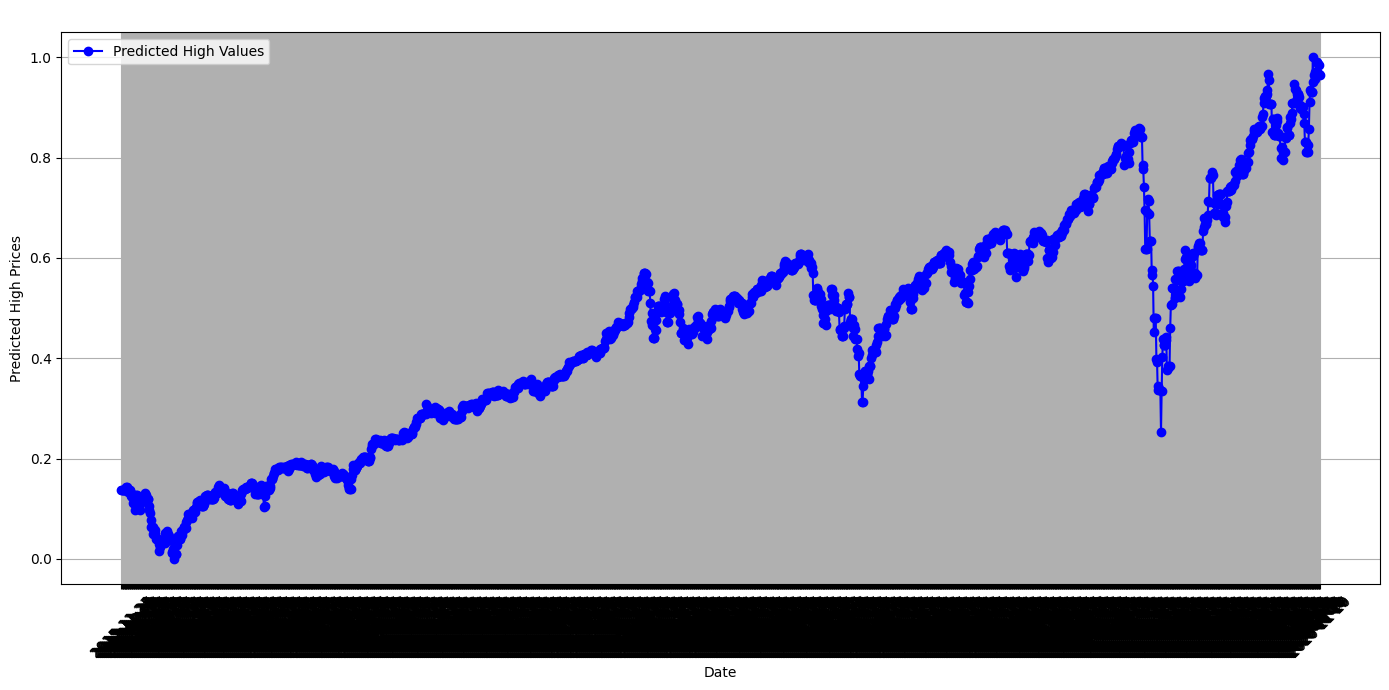

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(yahoo_new['Date'], yahoo_new['High'], label='Predicted High Values', marker='o', linestyle='-', color='blue')
plt.title(' ')
plt.xlabel('Date')
plt.ylabel('Predicted High Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_new['High'] = scaler.fit_transform(yahoo_new['High'].values.reshape(-1, 1))


<ipython-input-8-e25dd3797dca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yahoo_new['High'] = scaler.fit_transform(yahoo_new['High'].values.reshape(-1, 1))


In [ ]:
import numpy as np

def create_sequences(values, sequence_length):
    sequences = []
    for i in range(len(values) - sequence_length):
        sequence = values[i:(i + sequence_length)]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 30
sequences = create_sequences(yahoo_new['High'].values, sequence_length)


In [ ]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
import torch
import torch.nn as nn

class LSTMModelWithBatchNormAndDropout(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, dropout_rate=0.2):
        super(LSTMModelWithBatchNormAndDropout, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Dropout layer applied to the output of the LSTM layer
        self.dropout = nn.Dropout(dropout_rate)

        # Batch Normalization applied to the output of the LSTM layer
        # Note: The number of features for BatchNorm1d is set to hidden_layer_size because
        # we're applying it on the output of the LSTM layer for each time step.
        self.batch_norm = nn.BatchNorm1d(hidden_layer_size)

        # Linear layer that maps from hidden state space to output space
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)

        # Apply dropout to the output of the LSTM layer
        lstm_out = self.dropout(lstm_out)

        # Since BatchNorm1d expects a 2D input (batch_size, num_features), we need to reshape
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_layer_size)  # Reshape to (batch_size*seq_len, hidden_layer_size)
        lstm_out = self.batch_norm(lstm_out)  # Apply BatchNorm
        lstm_out = lstm_out.view(-1, input_seq.size(1), self.hidden_layer_size)  # Reshape back to (batch_size, seq_len, hidden_layer_size)

        # Selecting the output at the final time step
        final_output = lstm_out[:, -1, :]

        predictions = self.linear(final_output)
        return predictions

model = LSTMModelWithBatchNormAndDropout()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
X_train_tensor = X_train_tensor.unsqueeze(-1)
y_train_tensor = torch.Tensor(y_train)

epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # Clears existing gradients from previous epoch
    output = model(X_train_tensor)
    loss = loss_function(output.view(-1), y_train_tensor)
    loss.backward()  # Does backpropagation and calculates gradients
    optimizer.step()  # Updates the weights accordingly

    print(f'Epoch {epoch+1} Loss: {loss.item()}')


Epoch 1 Loss: 0.5275946259498596
Epoch 2 Loss: 0.40578991174697876
Epoch 3 Loss: 0.36943092942237854
Epoch 4 Loss: 0.2899555563926697
Epoch 5 Loss: 0.2566392421722412
Epoch 6 Loss: 0.2313975989818573
Epoch 7 Loss: 0.1863887459039688
Epoch 8 Loss: 0.18831636011600494
Epoch 9 Loss: 0.17412392795085907
Epoch 10 Loss: 0.16151924431324005
Epoch 11 Loss: 0.16214610636234283
Epoch 12 Loss: 0.16546761989593506
Epoch 13 Loss: 0.16377070546150208
Epoch 14 Loss: 0.15424025058746338
Epoch 15 Loss: 0.1550242155790329
Epoch 16 Loss: 0.13223090767860413
Epoch 17 Loss: 0.12516050040721893
Epoch 18 Loss: 0.11792861670255661
Epoch 19 Loss: 0.11045919358730316
Epoch 20 Loss: 0.10758400708436966
Epoch 21 Loss: 0.09414572268724442
Epoch 22 Loss: 0.09832001477479935
Epoch 23 Loss: 0.08693941682577133
Epoch 24 Loss: 0.09158799052238464
Epoch 25 Loss: 0.08469915390014648
Epoch 26 Loss: 0.07667975127696991
Epoch 27 Loss: 0.07811997830867767
Epoch 28 Loss: 0.07707087695598602
Epoch 29 Loss: 0.06593593955039978


In [ ]:
yahoo_new['High'][-12:]

1813    1.000000
1814    0.950656
1815    0.963963
1816    0.957215
1817    0.970911
1818    0.970911
1819    0.970911
1820    0.990283
1821    0.987282
1822    0.985047
1823    0.966220
1824    0.964002
Name: High, dtype: float64

In [ ]:
sequence_length = 30

last_known_sequence = yahoo_new['High'][-sequence_length:].values.reshape(1, sequence_length, 1)


In [ ]:
last_date = pd.to_datetime(yahoo_new['Date'].iloc[-1])
next_100_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 101)]


In [ ]:
model.eval()
predictions = []

for _ in range(100):
    with torch.no_grad():
        current_sequence_tensor = torch.Tensor(last_known_sequence)
        next_point_pred = model(current_sequence_tensor)

        predictions.append(next_point_pred.item())

        last_known_sequence = np.roll(last_known_sequence, -1, axis=1)
        last_known_sequence[:, -1, :] = next_point_pred.numpy()

if isinstance(scaler, MinMaxScaler):
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [ ]:
predictions_df = pd.DataFrame({
    'date': next_100_dates,
    'predicted_high': predictions.reshape(-1)
})

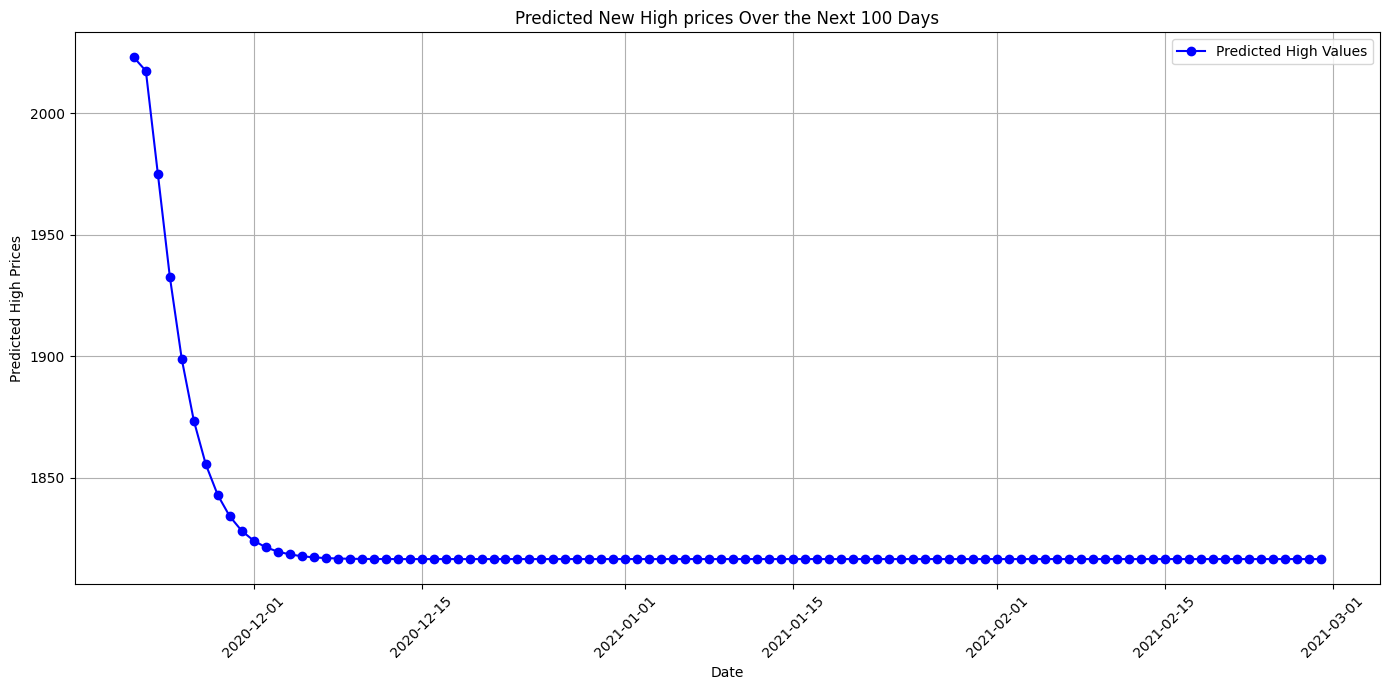

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions_df['date'], predictions_df['predicted_high'], label='Predicted High Values', marker='o', linestyle='-', color='blue')
plt.title('Predicted New High prices Over the Next 100 Days')
plt.xlabel('Date')
plt.ylabel('Predicted High Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
